# Gamma spec analysis

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gs_analysis as ga

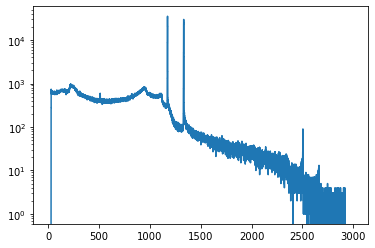

In [166]:
path = "test_data/Co_60_raised_1.spe"
counts, ebins = ga.get_spect(path)

ga.plot_spec(counts, erg=ebins)

## Peak finder
### SciPy.signal version

(ebins is x, count is the data in the file and y)
* smoothing func in ga removes noise

#### Peak detection process
(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2631518/)
- raw spec -> smooth spec -> baseline correction -> peaks
okay so can get raw, smoothed and peaks, baseline?

- look at scipy.signal savgol_filter too - looks where 2nd deriv is large, then finds width and then midpooint (https://stackoverflow.com/questions/47519626/using-numpy-scipy-to-identify-slope-changes-in-digital-signals)

In [128]:
from scipy.signal import find_peaks, peak_prominences, savgol_filter

[1398 3210 3646]


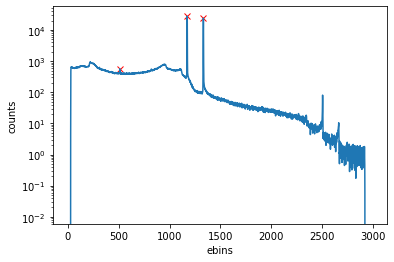

In [174]:
def sp_peak_finder(x, prominence, wlen):

    sf = ga.five_point_smooth(x)
    smooth = np.array(sf)
    sf2 = ga.five_point_smooth(smooth)
    smooth2 = np.array(sf2)
    peaks,_ = find_peaks(sf2, prominence = prominence, wlen = wlen)
    
    return(smooth2, peaks)

def peak_identifier(smooth_counts, ebins, peaks):
    plt.plot(ebins[peaks], smooth_counts[peaks], "xr"); plt.plot(ebins, smooth_counts)
    plt.xlabel('ebins')
    plt.ylabel('counts')
    plt.yscale('log') 
    plt.show
    
smoothed_counts, peaks = sp_peak_finder(counts, 90, 10)
print(peaks)

plot_sp = peak_identifier(smoothed_counts, ebins, peaks)

#still needs prominence as a variable but shouldnt be an issue if peaks are known - if unknown below is probs better

In [130]:
proms = peak_prominences(counts, peaks)[0]
print(proms)

#why is the first one zero? surely if it was 0 it wouldnt show up when i put the prominence to be at least 90??

[    0. 35274. 29723.]


<ipython-input-130-3419da99962f>:1: PeakPropertyWarning: some peaks have a prominence of 0
  proms = peak_prominences(counts, peaks)[0]


## Diff version
smooth, find maxima with scipy or 2nd deriv, then ?
(https://arxiv.org/pdf/hep-ex/9506013.pdf)

[3210 3645]


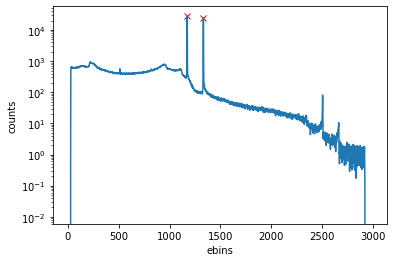

In [172]:
#fits a polynomial to the curve in the specified window
# then for the peaks - uses 2nd derivative, looks for places where 2nd deriv is at least half its max size
#then finds start and end points then mid points
# do the same method with the smoother from steve instead 

def peak_finder_savgol(x, wlen):
    smooth_sig = ga.five_point_smooth(x)
    smooth_signal = np.array(smooth_sig)
    smooth_sig2 = ga.five_point_smooth(smooth_signal)
    smooth_signal2 = np.array(smooth_sig2)
    d2x = savgol_filter(smooth_signal2, window_length=wlen, polyorder=2, deriv=2)
    max_d2x = np.max(np.abs(d2x))
    large = np.where(np.abs(d2x) > max_d2x/2)[0]
    peak_width = np.diff(large) > wlen
    peak_start= np.insert(large[1:][peak_width], 0, large[0])
    peak_end = np.append(large[:-1][peak_width], large[-1])
    mid_point = ((peak_start + peak_end) / 2).astype(np.int)

    return(smooth_signal2, mid_point) 

smooth_counts_savgol, peaks_savgol = peak_finder_savgol(counts, 11)
print(peaks_savgol)

plot_savgol = peak_identifier(smooth_counts_savgol, ebins, peaks_savgol)

#this one also uses the smoothing function on top of the savgol - takes out even more noise
#window length for savgol needs to be odd

[3209 3645]


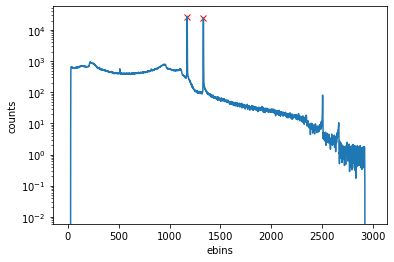

In [173]:
def peak_finder_diff(x, wlen):
    smooth_sig = ga.five_point_smooth(x)
    smooth_signal = np.array(smooth_sig)
    smooth_sig2 = ga.five_point_smooth(smooth_signal)
    smooth_signal2 = np.array(smooth_sig2)
    max_sig = np.max(np.abs(smooth_signal2))
    large = np.where(np.abs(smooth_signal2) > max_sig/2)[0]
    peak_width = np.diff(large) > wlen
    peak_start= np.insert(large[1:][peak_width], 0, large[0])
    peak_end = np.append(large[:-1][peak_width], large[-1])
    mid_point = ((peak_start + peak_end) / 2).astype(np.int)
    
    return(smooth_signal2, mid_point)

smooth_counts_diff, peaks_diff = peak_finder_diff(counts, 10)
print(peaks_diff)

plot_diff = peak_identifier(smooth_counts_diff, ebins, peaks_diff)

#same as above but minus the savgol filter - pretty much the same just more noise when plotting